# Run this Notebook

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Homework-3-Questions/blob/main/HW3_P3_MountainCarContinuous_REINFORCE.ipynb)  
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/DeepRLCourse/Homework-3-Questions/blob/main/HW3_P3_MountainCarContinuous_REINFORCE.ipynb)

# HW3: REINFORCE with continous action space in MountainCarContinous
> - Full Name: **Asemaneh Nafe**
> - Student ID: **400105285**


This notebook implements the **REINFORCE policy gradient algorithm** to train an agent in the **MountainCarContinuous-v0** environment. The objective is to evaluate the performance and stability of REINFORCE in a continuous action space.

Follow the instructions in each section to complete the homework.

**Grading Breakdown:**

- Practical Implementation: 80 points
- Conceptual Understanding: 20 points

# Setup

All required packages are pre-installed if using Google Colab.

Import the following libraries.

In [14]:
# Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import gym
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import base64
import imageio
import IPython
import logging
import warnings

# Disable warnings
logging.getLogger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# DEVICE
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

Configure Matplotlib for Interactive and XKCD-Style Plots

In [15]:
# Set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)

Record and Embed Simulation Videos in Jupyter Notebook

<b>embed_mp4:</b> Converts an MP4 video into a base64-encoded HTML tag for display in Jupyter Notebook.
<br>
<b>record_simulation:</b> Runs a policy in the environment, records the simulation, and saves it as an MP4 video.

In [16]:
def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)

def record_simulation(env, policy_net, filename, episodes=1, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(episodes):
            state = env.reset()
            frame = env.render()  # Capture the first frame
            video.append_data(frame[0])

            done = False
            while not done:
                state_tensor = torch.FloatTensor(state).to(DEVICE)
                mean, _ = policy_net(state_tensor)
                action = mean.item()
                state, _, terminated, truncated, _ = env.step([action])

                frame = env.render()  # Capture the frame after taking the action
                video.append_data(frame[0])

                done = terminated or truncated
    return embed_mp4(filename)

# Explore the environment (10 points)

Initialize MountainCarContinuous Environment and Display State & Action Spaces

In [17]:
# Create the MountainCarContinuous environment
env = gym.make("MountainCarContinuous-v0")

# Print observation and action space
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)

Observation Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action Space: Box(-1.0, 1.0, (1,), float32)


**Question 1: (5 points)**

How are the observation and action spaces defined in the MountainCarContinuous environment?

.....</br>
Observation Space: Box[-1.2  -0.07] x Box[0.6  0.07]

A 2D space with:

Position of the car in [-1.2  -0.07]

Velocity in [0.6  0.07]

Action Space: Box(-1.0, 1.0)

A continuous scalar force applied to the car within [-1, 1].
.....</br>


Define a Random Policy for Action Selection  

In [18]:
class RandomPolicy(object):

    def __init__(self, action_space_n):
        self.action_space_n = action_space_n

    def __call__(self, state):
        action_values, nan = torch.rand(self.action_space_n), np.nan
        return action_values, nan

Visualize the random policy.

In [19]:
random_policy = RandomPolicy(env.action_space.shape[0])

record_simulation(gym.make("MountainCarContinuous-v0", render_mode='rgb_array', new_step_api=True), random_policy, "Video_MountainCarContinuous_random_policy")

**Question 2: (5 points)**

How could an agent reach the goal in the MountainCarContinuous environment while using the least amount of energy? Explain a scenario describing the agent's behavior during an episode with most optimal policy.

.....</br>
The car must build momentum to reach the flag at x ≥ 0.45.
Optimal Policy:
Instead of immediately applying max force, the agent should swing back and forth.
It should apply controlled force at the right moments to amplify oscillations.
This minimizes total energy spent while still reaching the goal efficiently.

.....</br>


# Agent with REINFORCE in a continuous action space in MountainCarContinuous-v0 (80 points)

### Policy Network Definition (10 points)

In continuous action spaces, instead of choosing from a discrete set of actions, the policy network learns a Gaussian distribution
$\pi_\theta(a|s)$ over possible actions. The agent then samples an action from this distribution:

$$a \sim \mathcal{N}(\mu_\theta(s), \sigma_\theta(s))$$

where:

- $\mu_\theta(s)$ is the mean of the action distribution.
- $\sigma_\theta(s)$ is the standard deviation (exploration factor).

The network is trained using policy gradients, reinforcing actions that lead to better rewards.


In [24]:
import torch.nn.functional as F

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mu = nn.Linear(hidden_size, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim), requires_grad=True)

    def forward(self, x):
        o1 = F.relu(self.fc1(x))
        o2 = F.relu(self.fc2(o1))
        mu = self.mu(o2 + o1)
        return mu, self.log_std


### Computing Discounted Returns (15 points)

To implement a function that calculates the discounted return for each timestep in an episode.

$$[
G_t = \sum_{k=0}^{T-t} \gamma^k R_{t+k}
]$$

In [21]:
def compute_returns(rewards, gamma=0.99):
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G  # Discounted sum
        returns.insert(0, G)  # Store at the beginning
    return torch.tensor(returns)


### Implementing the REINFORCE Algorithm in continuous action space (45 points)

To train the agent using the standard policy gradient method.
The REINFORCE algorithm updates policy parameters by using the log-probability of actions multiplied by the discounted return.

This algorithm optimizes a **stochastic policy** $( \pi_{\theta}(a_t \mid s_t) )$ by updating its parameters in the direction that increases expected rewards. The update rule is based on the **policy gradient theorem**:  

$$[
\theta \leftarrow \theta + \alpha \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) G_t
]$$

where:  

- $( \theta )$ are the policy parameters (weights of the neural network).  
- $( \alpha )$ is the learning rate.  
- $( G_t )$ is the **discounted return** from timestep $( t )$:  

- $( \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) )$ is the gradient of the log-probability of the selected action, used to adjust the policy in the correct direction.

In [22]:
def reinforce(env, policy_net, optimizer, num_episodes=1000, gamma=0.99):
    rewards_per_episode = []

    for episode in range(num_episodes):
        log_probs = []
        rewards = []
        reset_result = env.reset()
        state = reset_result[0] if isinstance(reset_result, tuple) else reset_result

        done = False
        while not done:
            state_tensor = torch.FloatTensor(state).to(DEVICE)
            mu, sigma = policy_net(state_tensor)
            sigma = torch.exp(sigma)
            dist = Normal(mu, sigma)
            action = dist.sample()
            log_prob = dist.log_prob(action)

            step_result = env.step([action.item()])

            if len(step_result) == 4:  # Gym v26+
                next_state, reward, done, info = step_result
                terminated, truncated = done, False  # Treat `done` as `terminated`
            else:  # Older Gym versions
                next_state, reward, terminated, truncated, info = step_result

            done = terminated or truncated
            state = next_state
            log_probs.append(log_prob)
            rewards.append(reward)

        # Compute discounted returns
        returns = compute_returns(rewards, gamma)

        # Compute policy loss
        policy_loss = []
        for log_prob, G in zip(log_probs, returns):
            policy_loss.append(-log_prob * G)  # Gradient ascent on expected return

        optimizer.zero_grad()
        torch.stack(policy_loss).sum().backward()
        optimizer.step()

        episode_reward = sum(rewards)
        rewards_per_episode.append(episode_reward)

        if (episode + 1) % 50 == 0:
            print(f"Episode {episode + 1}, Reward: {episode_reward}")

    return rewards_per_episode


### Training (10 points)

To define key hyperparameters that influence training efficiency and convergence.

Hyperparameters like learning rate, discount factor, and number of episodes significantly impact the training process. Proper tuning is necessary to ensure stable learning while avoiding slow convergence or premature convergence to suboptimal policies.

In [25]:
# TODO: Define all necessary hyperparameters
INPUT_DIM = env.observation_space.shape[0]     # TODO
OUTPUT_DIM = env.action_space.shape[0] # TODO
LEARNING_RATE = 3e-3 # TODO
DISCOUNT_FACTOR = 0.99
NUM_EPISODES = 2000

# Initialize Policy
policy = PolicyNetwork(INPUT_DIM, OUTPUT_DIM).to(DEVICE)

# Optimizer
optimizer= optim.Adam(policy.parameters(), lr=LEARNING_RATE)

# Training
print("Training REINFORCE Algorithm for Continuous Action Space:")
rewards = reinforce(env, policy, optimizer, num_episodes=NUM_EPISODES, gamma=DISCOUNT_FACTOR)

Training REINFORCE Algorithm for Continuous Action Space:
Episode 50, Reward: -90.7575900388004
Episode 100, Reward: -133.33886587183616
Episode 150, Reward: -74.35092770524732
Episode 200, Reward: -78.13502501508226
Episode 250, Reward: -61.97519949474924
Episode 300, Reward: -57.16977333017006
Episode 350, Reward: 38.63034265864006
Episode 400, Reward: 1.08129751744994
Episode 450, Reward: 0.3892473789435371
Episode 500, Reward: -141.07096391110136
Episode 550, Reward: -101.75081626651406
Episode 600, Reward: 9.902873363163948
Episode 650, Reward: 56.819660180743355
Episode 700, Reward: -27.149425230909003
Episode 750, Reward: -60.73426094968059
Episode 800, Reward: -150.76125411286554
Episode 850, Reward: 33.871600319722305
Episode 900, Reward: 13.322648661910264
Episode 950, Reward: 76.26736246418096
Episode 1000, Reward: 72.21128515788655
Episode 1050, Reward: 87.42097032454666
Episode 1100, Reward: 77.47221544459426
Episode 1150, Reward: 84.01498821971403
Episode 1200, Reward: 83

# Results (10 points)

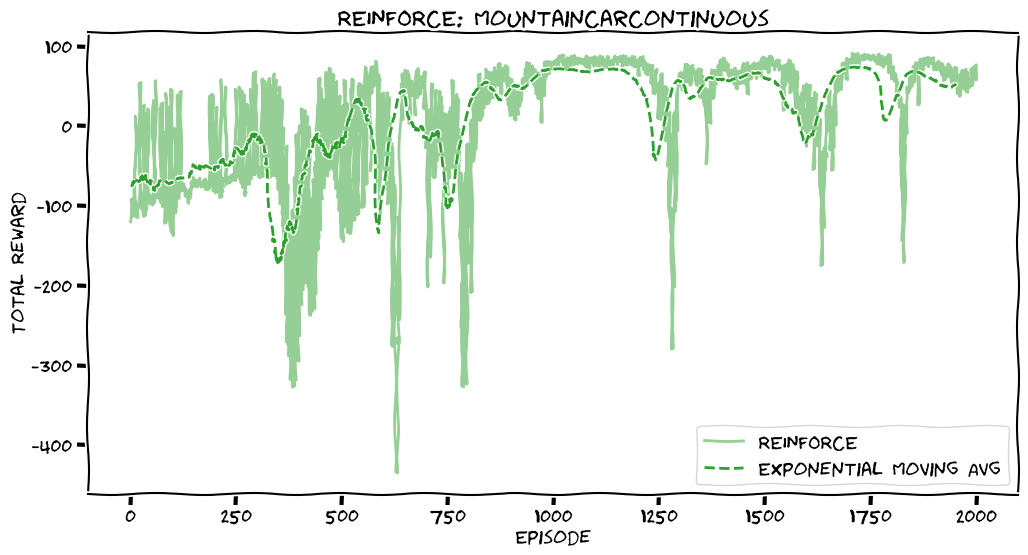

In [26]:
# Plotting Results
window_size = 50  # Moving average window size

# Exponential Moving Average calculation
def exponential_moving_average(data, window_size):
    alpha = 2 / (window_size + 1)  # Smoothing factor
    return np.convolve(data, [alpha * (1 - alpha) ** i for i in range(window_size)], mode='valid')

plt.plot(rewards, label="REINFORCE", alpha=0.5, color='tab:green')

# Plotting exponential moving averages
plt.plot(exponential_moving_average(rewards, window_size), label="Exponential Moving Avg", linestyle='--', color='tab:green')

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.title("REINFORCE: MountainCarContinuous")
plt.show()

In [27]:
mean_reward, std_reward = np.mean(rewards), np.std(rewards)
print(f"mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}")

mean_reward = 12.72 +/- 83.1476


**Question 3: (10 points)**

What strategies can be employed to reduce catastrophic forgetting in continuous action space environments like MountainCarContinuous?
</br>(Hint: experience replay or target networks)

.....</br>
.....</br>


# Simulation

In [28]:
# Record the simulation using the optimal policy
record_simulation(gym.make("MountainCarContinuous-v0", render_mode='rgb_array', new_step_api=True), policy, "Video_MountainCarContinuous_REINFORCE")